# Practical Usage of Lava w/ custom input from the lab

The input data from the lab used in this example consists of a sequence of timestamps where a specific neuron fired. The data is stored in a csv file, where each value is a timestamp (in milliseconds). 

Thus, the input layer only requires 1 connection at each timestep. We will assume the network contains 5 neurons for the sake of this example.

Let's start by defining the middle layer, the 2-layered feed-forward network of LIF neurons

In [145]:
from lava.proc.lif.process import LIF
from lava.proc.dense.process import Dense

LIF?

Init signature: LIF(*args, **kwargs)
Docstring:     
Leaky-Integrate-and-Fire (LIF) neural Process.

LIF dynamics abstracts to:
u[t] = u[t-1] * (1-du) + a_in         # neuron current
v[t] = v[t-1] * (1-dv) + u[t] + bias  # neuron voltage
s_out = v[t] > vth                    # spike if threshold is exceeded
v[t] = 0                              # reset at spike

Parameters
----------
shape : tuple(int)
    Number and topology of LIF neurons.
u : float, list, numpy.ndarray, optional
    Initial value of the neurons' current.
v : float, list, numpy.ndarray, optional
    Initial value of the neurons' voltage (membrane potential).
du : float, optional
    Inverse of decay time-constant for current decay. Currently, only a
    single decay can be set for the entire population of neurons.
dv : float, optional
    Inverse of decay time-constant for voltage decay. Currently, only a
    single decay can be set for the entire population of neurons.
bias_mant : float, list, numpy.ndarray, optiona

In [146]:
import numpy as np

# Create Processes
lif1 = LIF(shape=(5,),  # There are 5 neurons
           vth=10,  # TODO: Verify these initial values
           v=0,
           dv=0.5,
           du=0.5,
           bias_mant=0,
           name="lif1")

dense = Dense(weights=np.random.rand(2, 5),     # 5 nodes in the input side, 2 nodes on the output side 
              name="dense1") 

lif2 = LIF(shape=(2,),
           vth=10,
           v=0,
           dv=0.5,
           du=0.5,
           bias_mant=0,
           name="lif2")

Should the Dense layer contain 2 output nodes? I was thinking each output node could correspond to the probability of the events "network burst detected" or "network burst not detected" at each timestep. It might be better to represent it with a single node?

Let's take a look at the ports and connections of the middle layer:

In [147]:
for proc in [lif1, dense, lif2]:
    for port in proc.in_ports:
        print(f"Proc: {proc.name:<5} Port Name: {port.name:<5} Size: {port.size}")
    for port in proc.out_ports:
        print(f"Proc: {proc.name:<5} Port Name: {port.name:<5} Size: {port.size}")

Proc: lif1  Port Name: a_in  Size: 5
Proc: lif1  Port Name: s_out Size: 5
Proc: dense1 Port Name: s_in  Size: 5
Proc: dense1 Port Name: a_out Size: 2
Proc: lif2  Port Name: a_in  Size: 2
Proc: lif2  Port Name: s_out Size: 2


After verifying the input and output Ports of the middle layer, we can connect the network to complete the LIF-Dense-LIF structure

In [148]:
lif1.s_out.connect(dense.s_in)
dense.a_out.connect(lif2.a_in)

Take a look at the random weights of the Dense Layer:

In [149]:
dense.weights.get()

array([[0.13743684, 0.24508359, 0.15474068, 0.25704039, 0.00494908],
       [0.35851092, 0.79598508, 0.7221887 , 0.35856429, 0.73813769]])

### Record Internal Vars over time
To record the evolution of the internal variables over time, we need a `Monitor`. For this example, we want to record the membrane potential of both `LIF` Layers, hence we need 2 `Monitors`.

We can define the `Var` that a `Monitor` should record, as well as the recording duration, using the `probe` function

In [150]:
from lava.proc.monitor.process import Monitor

monitor_lif1 = Monitor()
monitor_lif2 = Monitor()

num_steps = 100     # TODO: Check the number of steps to run the simulation for

# Connect the monitors to the variables we want to monitor
monitor_lif1.probe(lif1.v, num_steps)
monitor_lif2.probe(lif2.v, num_steps)

## Create the Custom Input Layer

### Define function to read the input data from the csv file and generate the corresponding spike events

In [151]:
import pandas as pd

def read_spike_events(file_path: str):
    """Reads the spike events from the input file and returns them as a numpy array

    Args:
        file_path (str): name of the file containing the spike events
    """
    spike_events = []

    try:
        # Read the spike events from the file
        df = pd.read_csv(file_path, header=None)

        # Detect errors
        if df.empty:
            raise Exception("The input file is empty")

        # Convert the scientific notation values to integers if any exist
        df = df.applymap(lambda x: int(float(x)) if (isinstance(x, str) and 'e' in x) else x)

        # Convert the dataframe to a numpy array
        spike_events = df.to_numpy()
        return spike_events[0]
    except Exception as e:
        print("Unable to read the input file: ", file_path, " error:", e)

    return spike_events

In [152]:
# Call the function to read the spike events
file_path = "./canal60.csv"
spike_events = read_spike_events(file_path)
print("Spike events: ", spike_events.shape, spike_events[:10])

Spike events:  (289,) [104000. 124000. 135000. 171000. 177000. 184000. 190000. 194000. 200000.
 200000.]


Define the SpikeEvent Generator Interface

In [153]:
from lava.magma.core.process.process import AbstractProcess
from lava.magma.core.process.variable import Var
from lava.magma.core.process.ports.ports import OutPort

class SpikeEventGen(AbstractProcess):
    """Input Process that generates spike events based on the input file

    Args:
        shape (tuple): Shape of the output port
        file_name (str): Name of the file containing the spike events
    """
    def __init__(self, shape: tuple, spike_events: np.ndarray) -> None:
        super().__init__()
        self.s_out = OutPort(shape=shape)
        self.spike_events = Var(shape=spike_events.shape, init=spike_events)

Implement the `SpikeEventGenerator` Model

In [154]:
from lava.magma.core.model.py.model import PyLoihiProcessModel  # Processes running on CPU inherit from this class
from lava.magma.core.resources import CPU
from lava.magma.core.decorator import implements, requires
from lava.magma.core.sync.protocols.loihi_protocol import LoihiProtocol
from lava.magma.core.model.py.type import LavaPyType
from lava.magma.core.model.py.ports import PyOutPort

@implements(proc=SpikeEventGen, protocol=LoihiProtocol)
@requires(CPU)
class PySpikeEventGenModel(PyLoihiProcessModel):
    """Spike Event Generator Process implementation running on CPU (Python)
    Args:
    """
    s_out: PyOutPort = LavaPyType(PyOutPort.VEC_DENSE, float)   # IT IS POSSIBLE TO SEND FLOATS AFTER ALL
    spike_events: np.ndarray = LavaPyType(np.ndarray, np.ndarray)   # TODO: Check if we should keep it as a numpy array, or transform it to a list

    def __init__(self, proc_params) -> None:
        super().__init__(proc_params=proc_params)
        # print("spike events", self.spike_events.__str__())    # TODO: Check why during initialization the variable prints the class, while during run it prints the value
        self.curr_spike_idx = 0     # Index of the next spiking event to send
        self.virtual_time_step_interval = 10000    # Arbitrary time between time steps (in microseconds). This is not a real time interval
        self.init_offset = 100000                  # Arbitrary offset to start the simulation (in microseconds)

    def run_spk(self) -> None:
        spike_data = np.zeros(self.s_out.shape) # Initialize the spike data to 0
        
        # Use random spikes to test it
        # spike_data[0] = np.random.random()  # Only 1 neuron is sending data (spikes)
        # self.curr_spike_idx += 1

        # Use the spike events from the file
        # print("spike events: ", self.spike_events[:5])
        # TODO: For now we are using the time_step as the time measurement that will simulate real-time activity. It would be better to have access to the running time
        
        #print("time step:", self.time_step)
        # If the current simulation time is greater than the next spike event, send a spike
        currTime = self.init_offset + self.time_step*self.virtual_time_step_interval
        if currTime >= self.spike_events[self.curr_spike_idx]:
            spike_data[0] = 1   # Send a spike
            print(f"sending spike event at time: {currTime}({self.time_step}) spike idx: {self.curr_spike_idx} spike time: {self.spike_events[self.curr_spike_idx]}")
            self.curr_spike_idx += 1

        # Send spikes
        print("sending spike_data: ", spike_data, " at step: ", self.time_step)
        self.s_out.send(spike_data)

        # Stop the Process if there are no more spike events to send. (It will stop all the connected processes)
        # TODO: Should it be another process that stops the simulation? Such as the last LIF process
        # if self.curr_spike_idx >= 5: # len(self.spike_events):
            # self.pause()


## Connect the Custom Input Layer to the middle layer

To define the connectivity between the `SpikeGenerator` and the first `LIF` population, we use another `Dense` Layer.

In [155]:
# Create the Input Process
spike_event_gen = SpikeEventGen(shape=(5,), spike_events=spike_events)

# Instantiante a Dense Layer to connect the SpikeEventGen to the middle layer
dense_input = Dense(weights=np.eye(5))     # 1-1 connectivity with the Middle Layer (should be a 5x5 matrix right now)

# Connect the SpikeEventGen to the Dense Layer
spike_event_gen.s_out.connect(dense_input.s_in)

# Connect the Dense_Input to the LIF1 Layer
dense_input.a_out.connect(lif1.a_in)

### Take a look at the connections in the Input Layer

In [156]:
for proc in [spike_event_gen, dense_input, lif1]:
    for port in proc.in_ports:
        print(f"Proc: {proc.name:<5} Port Name: {port.name:<5} Size: {port.size}")
    for port in proc.out_ports:
        print(f"Proc: {proc.name:<5} Port Name: {port.name:<5} Size: {port.size}")

Proc: Process_68 Port Name: s_out Size: 5
Proc: Process_69 Port Name: s_in  Size: 5
Proc: Process_69 Port Name: a_out Size: 5
Proc: lif1  Port Name: a_in  Size: 5
Proc: lif1  Port Name: s_out Size: 5


## Execution
Now that we have defined the network, we can execute it. We will use the `run` function to execute the network.

### Run Configuration and Conditions

In [157]:
from lava.magma.core.run_conditions import RunContinuous, RunSteps
from lava.magma.core.run_configs import Loihi1SimCfg

# run_condition = RunContinuous()   # TODO: Change to this one
run_condition = RunSteps(num_steps=10)
run_cfg = Loihi1SimCfg(select_tag="floating_pt")   # TODO: Check why we need this select_tag="floating_pt"

### Execute

In [158]:
lif2.run(condition=run_condition, run_cfg=run_cfg)

sending spike event at time: 110000(1) spike idx: 0 spike time: 104000.0
sending spike_data:  [1. 0. 0. 0. 0.]  at step:  1
sending spike_data:  [0. 0. 0. 0. 0.]  at step:  2
sending spike event at time: 130000(3) spike idx: 1 spike time: 124000.0
sending spike_data:  [1. 0. 0. 0. 0.]  at step:  3
sending spike event at time: 140000(4) spike idx: 2 spike time: 135000.0
sending spike_data:  [1. 0. 0. 0. 0.]  at step:  4
sending spike_data:  [0. 0. 0. 0. 0.]  at step:  5
sending spike_data:  [0. 0. 0. 0. 0.]  at step:  6
sending spike_data:  [0. 0. 0. 0. 0.]  at step:  7
sending spike event at time: 180000(8) spike idx: 3 spike time: 171000.0
sending spike_data:  [1. 0. 0. 0. 0.]  at step:  8
sending spike event at time: 190000(9) spike idx: 4 spike time: 177000.0
sending spike_data:  [1. 0. 0. 0. 0.]  at step:  9
sending spike event at time: 200000(10) spike idx: 5 spike time: 184000.0
sending spike_data:  [1. 0. 0. 0. 0.]  at step:  10


### Retrieve recorded data

In [159]:
data_lif1 = monitor_lif1.get_data()
data_lif2 = monitor_lif2.get_data()

In [160]:
data_lif1

{'lif1': {'v': array([[ 0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
           0.000000e+00],
         [ 1.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
           0.000000e+00],
         [-1.800000e+01,  0.000000e+00,  0.000000e+00,  0.000000e+00,
           0.000000e+00],
         [ 0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
           0.000000e+00],
         [-7.370000e+02,  0.000000e+00,  0.000000e+00,  0.000000e+00,
           0.000000e+00],
         [ 0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
           0.000000e+00],
         [-5.969700e+04,  0.000000e+00,  0.000000e+00,  0.000000e+00,
           0.000000e+00],
         [ 0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
           0.000000e+00],
         [-4.835456e+06,  0.000000e+00,  0.000000e+00,  0.000000e+00,
           0.000000e+00],
         [ 0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
           0.000000e+00],
         [ 0.000000e+00,  0

In [161]:
data_lif2

{'lif2': {'v': array([[ 0.00000000e+00,  0.00000000e+00],
         [ 7.99250586e-01,  2.97338668e+00],
         [-1.43865106e+01, -5.35209603e+01],
         [ 0.00000000e+00,  0.00000000e+00],
         [-5.82516241e+02, -2.16724038e+03],
         [ 0.00000000e+00,  0.00000000e+00],
         [-4.71836780e+04, -1.75546112e+05],
         [ 0.00000000e+00,  0.00000000e+00],
         [-3.82187778e+06, -1.42192347e+07],
         [ 0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00

### Plot the recorded data

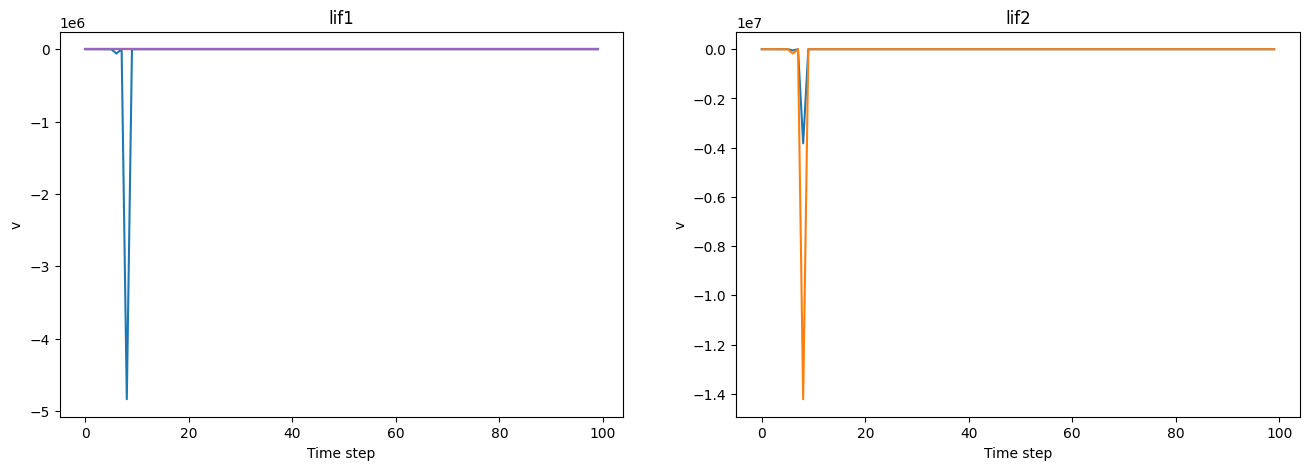

In [162]:
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt

# Create a subplot for each monitored variable
fig = plt.figure(figsize=(16, 5))
ax0 = fig.add_subplot(121)
ax1 = fig.add_subplot(122)

# Plot the data
monitor_lif1.plot(ax0, lif1.v)
monitor_lif2.plot(ax1, lif2.v)

## Stop the Runtime

In [163]:
lif2.stop()